# GPT experiments

In [1]:
%%javascript
$('<div id="toc"></div>').css({position: 'fixed', top: '120px', left: 0}).appendTo(document.body);
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js');


<IPython.core.display.Javascript object>

# Imports and functions

In [263]:
import pandas as pd
import numpy as np
import torch
import requests
import json
import re
import random
from tqdm import tqdm, trange
import time
import copy
import backoff
import os

from sklearn.metrics import matthews_corrcoef
from rouge_score import rouge_scorer
import seaborn as sn
import matplotlib.pyplot as plt

In [4]:
import openai
import tiktoken
OPENAI_API_KEY = "" # your openai api key
openai.api_key = OPENAI_API_KEY


In [5]:
def normalize_text(text):
    text = text.replace('&amp;', '&')
    text = text.replace('\xa0', '')
    text = re.sub(r'http\S+', '', text)
    text = " ".join(text.split())
    return text

@backoff.on_exception(backoff.expo, openai.error.RateLimitError)
def completions_with_backoff(**kwargs):
    return openai.ChatCompletion.create(**kwargs)

def sample_from_df(df, N, column_name, level=2, seed = 0):
    
    tmp = df[df[column_name]==level]
    tmp2 = tmp.sample(N, random_state=seed)
    examples_not_normalized = tmp2['tweet_text'].tolist()
    examples = []
    for e in examples_not_normalized:
        examples.append(normalize_text(e))
    ids = tmp2['tweet_id'].tolist()

    return examples, ids

In [471]:
conspiracy_definitions = ["Suppressed cures: Narratives which propose that effective medications for COVID-19 were available, but whose existence or effectiveness has been denied by authorities, either for financial gain by the vaccine producers or some other harmful intent.",
                         "Behavior control: Narratives containing the idea that the pandemic is being exploited to control the behavior of individuals, either directly through fear, through laws which are only accepted because of fear, or through techniques which are impossible with today’s technology, such as mind control through microchips.",
                         "Anti vaccination: Narratives that suggest that the COVID-19 vaccines serve some hidden nefarious purpose in this category. Examples include the injection of tracking devices, nanites or an intentional infection with COVID-19, but not concerns about vaccine safety or efficacy, or concerns about the trustworthiness of the producers.",
                         "Fake virus: Narratives saying that there is no COVID-19 pandemic or that the pandemic is just an over-dramatization of the annual flu season. Example intent is to deceive the population in order to hide deaths from other causes, or to control the behavior of the population through irrational fear.",
                         "Intentional pandemic: Narratives claiming that the pandemic is the result of purposeful human action pursuing some illicit goal. Does not include asserting that COVID-19 is a bioweapon or discussing whether it was created in a labora-tory since this does not prelude the possibility that it was released accidentally.",
                         "Harmful radiation: Narratives that connect COVID-19 to wireless transmissions, especially from 5 G equipment, claiming for example that 5 G is deadly and that COVID-19 is a coverup, or that 5 G allows mind control via microchips injected in the bloodstream.",
                         "Depopulation: Conspiracy theories on population reduction or population growth control suggest that either COVID-19 or the vaccines are being used to reduce population size, either by killing people or by rendering them infertile. In some cases, this is directed against specific ethnic groups.",
                         "New world order: New World Order (NWO) is a preexisting conspiracy theory which deals with the secret emerging totalitarian world government. In the context of the pandemic, this usually means that COVID-19 is being used to bring about this world government through fear of the virus or by taking away civil liberties, or some other, implausible ideas such as mind control.",
                         "Satanism: Narratives in which the perpetrators are alleged to be some kind of satanists, perform objectionable rituals, or make use of occult ideas or symbols. May involve harm or sexual abuse of children, such as the idea that global elites harvest adrenochrome from children."
                         ]


conspiracy_names = ["Suppressed cures",
                   "Behavior control",
                   "Anti vaccination",
                   "Fake virus",
                   "Intentional pandemic",
                   "Harmful radiation",
                   "Depopulation",
                   "New world order",
                   "Satanism"]

conspiracy_short_names = ['sc',
                         'bmc',
                         'av',
                         'fv',
                         'ip',
                         'hri',
                         'prc',
                         'nwo',
                         'sat']

conspiracy_short_names_plot = ['SUP',
                              'BHC',
                              'AVX',
                              'FAK',
                              'INT',
                              'HAR',
                              'DEP',
                              'NWO',
                              'SAT']

# Load Data

In [318]:
path = path/to/mediaeval/data/
test_df = pd.read_csv(path+'test-merged-task-1.csv')
train_df = pd.read_csv(path+'task_1_dev.csv')
d = {}
new_c = ['tweet_id', 'sc', 'bmc', 'av', 'fv', 'ip', 'hri', 'prc', 'nwo', 'sat', 'tweet_text']
for c in range(0, len(train_df.columns)):
    d[train_df.columns[c]]=new_c[c]
train_df = train_df.rename(columns = d)

In [320]:
binary_test_df = test_df.replace(3, 2)
binary_train_df = train_df.replace(3, 2)
binary_train_df['tweet_id'].iloc[2] = 3

/opt/tmp/ipykernel_406667/3620739253.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binary_train_df['tweet_id'].iloc[2] = 3


In [321]:
binary_test_df_01 = binary_test_df.copy()
for i in range(0, len(binary_test_df)):
    binary_test_df_01.iloc[i, 1:10] = binary_test_df_01.iloc[i, 1:10] -1

# Definition generations

## From the examples

In [214]:
random_seeds = [0, 1, 2, 3, 4]
system_message = "You will be given two sets of tweets. The first set of tweets contains examples of texts that mention the same concept. The second set of tweets contains examples of texts that mention other concepts, but not the same concept that tweets from the first set. Your task is to provide the definition of the concept present in the first set."

for random_seed in random_seeds:
    messages = []
    for c in conspiracy_short_names:
        positive_examples, positive_ids = sample_from_df(binary_train_df, N=25, column_name=c, level=2, seed = random_seed)
        negative_examples, negative_ids = sample_from_df(binary_train_df, N=25, column_name=c, level=1, seed = random_seed)

        examples = """First set of tweets:
"""
        for p in positive_examples:
            examples+=' - '+p+'\n'

        examples+="""
Second set of tweets:
"""
        for n in negative_examples:
            examples+=' - '+n+'\n'

        user_message = examples+"""

Given those two sets of tweets, what is the definition of the concept present in the first set that is not present in the second set of tweets? Start your answer with: 'The definition of the concept is'"""

        message = [
        {"role":"system", "content":system_message},
        {"role": "user", "content": user_message}
        ]
        messages.append(message)
    
    responses = []
    for i in trange(0, len(messages)):
        message = messages[i]
        response = completions_with_backoff(
            model="gpt-3.5-turbo",
            messages=message,
            temperature=0
        )
        responses.append(response)
        
    save_df = pd.DataFrame()
    save_df['prompts'] = messages
    save_df['responses'] = responses
    save_df.to_csv(path+'gpt/example_generated_definitions_seed_%i.csv'%(random_seed), index=False)
    
    


  0%|                                                         | 0/9 [00:03<?, ?it/s]


KeyboardInterrupt: 

In [302]:
eg_definitions_list = []

for seed in range(0, 5):
    save_df = pd.read_csv(path+'gpt/example_generated_definitions_seed_'+str(seed)+'.csv')
    
    eg_definitions = []
    for i in range(0, 9):
        j = json.loads(save_df['responses'].tolist()[i])

        eg_definitions.append(j['choices'][0]['message']['content'])
    eg_definitions_list.append(fs_definitions)

## Paper definitions

In [20]:
conspiracy_definitions = ["Suppressed cures: Narratives which propose that effective medications for COVID-19 were available, but whose existence or effectiveness has been denied by authorities, either for financial gain by the vaccine producers or some other harmful intent.",
                         "Behavior control: Narratives containing the idea that the pandemic is being exploited to control the behavior of individuals, either directly through fear, through laws which are only accepted because of fear, or through techniques which are impossible with today’s technology, such as mind control through microchips.",
                         "Anti vaccination: Narratives that suggest that the COVID-19 vaccines serve some hidden nefarious purpose in this category. Examples include the injection of tracking devices, nanites or an intentional infection with COVID-19, but not concerns about vaccine safety or efficacy, or concerns about the trustworthiness of the producers.",
                         "Fake virus: Narratives saying that there is no COVID-19 pandemic or that the pandemic is just an over-dramatization of the annual flu season. Example intent is to deceive the population in order to hide deaths from other causes, or to control the behavior of the population through irrational fear.",
                         "Intentional pandemic: Narratives claiming that the pandemic is the result of purposeful human action pursuing some illicit goal. Does not include asserting that COVID-19 is a bioweapon or discussing whether it was created in a labora-tory since this does not prelude the possibility that it was released accidentally.",
                         "Harmful radiation: Narratives that connect COVID-19 to wireless transmissions, especially from 5 G equipment, claiming for example that 5 G is deadly and that COVID-19 is a coverup, or that 5 G allows mind control via microchips injected in the bloodstream.",
                         "Depopulation: Conspiracy theories on population reduction or population growth control suggest that either COVID-19 or the vaccines are being used to reduce population size, either by killing people or by rendering them infertile. In some cases, this is directed against specific ethnic groups.",
                         "New world order: New World Order (NWO) is a preexisting conspiracy theory which deals with the secret emerging totalitarian world government. In the context of the pandemic, this usually means that COVID-19 is being used to bring about this world government through fear of the virus or by taking away civil liberties, or some other, implausible ideas such as mind control.",
                         "Satanism: Narratives in which the perpetrators are alleged to be some kind of satanists, perform objectionable rituals, or make use of occult ideas or symbols. May involve harm or sexual abuse of children, such as the idea that global elites harvest adrenochrome from children."
                         ]
hw_definitions = conspiracy_definitions


# Classification

## Zero Shot

In [257]:
definition = "hw" #hw, eg, none

for seed in range(0, 5):
    tmp = pd.read_csv(path = 'gpt/example_generated_definitions_seed_'+str(seed)+'.csv')
    definitions = [json.loads(tmp['responses'].tolist()[i])['choices'][0]['message']['content'] for i in range(0, 9)]
    
    for c in range(0, 9):
        current_conspiracy = conspiracy_names[c]
        print("Starting zero shot for conspiracy", current_conspiracy)

        system_message = """Your task is to label tweets regarding the '"""+current_conspiracy+"""' COVID-19 conspiracy theory. The available labels are: 1) mentions the conspiracy, 2) does not mention the conspiracy."""
        if definition=="hw":
            system_message += """
The definition of the '"""+current_conspiracy+"""' conspiracy theory is the following:
    """+hw_definitions[c]
        elif definition=="eg":
            system_message = """Your task is to label tweets regarding the '"""+current_conspiracy+"""' COVID-19 conspiracy theory. The available labels are: 1) mentions the conspiracy, 2) does not mention the conspiracy.
The definition of the '"""+current_conspiracy+"""' conspiracy theory is the following:
    """+definitions[c]

        responses = []
        messages_list = []
        for t in tqdm(binary_test_df['tweet_text'].tolist()[:]):

            user_message = """Tweet: """+t+"""

Does the tweet: 1) mention the '"""+current_conspiracy+"""' conspiracy, 2) do not mention the '"""+current_conspiracy+"""' conspiracy? Please include the corresponding number in your answer."""
            messages = [
             {"role":"system", "content":system_message},
             {"role": "user", "content": user_message}
            ]
            messages_list.append(messages)
            response = completions_with_backoff(
                model="gpt-3.5-turbo",
                messages=messages,
                temperature=0
            )
            responses.append(response)
        df_response = pd.DataFrame()

        df_response['tweet'] = binary_test_df['tweet_text'].tolist()
        df_response['prompt'] = messages_list
        df_response['response'] = responses

        df_response.to_csv(path+'gpt/'+str(definition)+'/'+str(conspiracy_short_names[c])+'_'+str(seed)+'.csv', index=False)
    

Starting zero shot for conspiracy Intentional pandemic


100%|█████████████████████████████████████████████| 823/823 [22:01<00:00,  1.61s/it]


Starting zero shot for conspiracy Harmful radiation


100%|█████████████████████████████████████████████| 823/823 [25:04<00:00,  1.83s/it]


Starting zero shot for conspiracy Depopulation


100%|█████████████████████████████████████████████| 823/823 [24:26<00:00,  1.78s/it]


Starting zero shot for conspiracy New world order


100%|█████████████████████████████████████████████| 823/823 [23:44<00:00,  1.73s/it]


Starting zero shot for conspiracy Satanism


100%|█████████████████████████████████████████████| 823/823 [23:32<00:00,  1.72s/it]


# Parsing answers

In [266]:
def parse_df(df):
    pred = []
    for r in range(0, len(df['response'].tolist())):
        txt = json.loads(df['response'].tolist()[r])['choices'][0]['message']['content']
        if "2" in txt:
            pred.append(0)
        elif "1" in txt:
            pred.append(1)
        else:
            print(r)
    return pred

In [358]:
for c in conspiracy_short_names:
    df = pd.read_csv(path+'gpt/hw/'+c+'_4.csv')
    pred_df = pd.DataFrame()
    pred_df['tweet_id'] = binary_test_df['tweet_id'].tolist()
    pred_df['tweet'] = df['tweet'].tolist()
    pred_df['prompt'] = df['prompt'].tolist()
    pred_df['response'] = df['response'].tolist()

    pred_df.to_csv(path+'gpt/paper_definition/raw_results_'+c+'.csv', index=False)
    

In [346]:
conspiracy_preds = []
for c in conspiracy_short_names:
    df = pd.read_csv(path+'gpt/hw/'+c+'_4.csv')
    conspiracy_preds.append(parse_df(df))

pred_df = pd.DataFrame()
pred_df['tweet_id'] = binary_test_df['tweet_id'].tolist()
for i in range(0, 9):
    pred_df[conspiracy_short_names[i]]=conspiracy_preds[i]
    
pred_df

,tweet_id,sc,bmc,av,fv,ip,hri,prc,nwo,sat
0,30001,0,1,0,1,1,0,0,1,0
1,30002,0,1,0,1,1,0,0,1,0
2,30003,0,1,0,1,1,0,0,1,0
3,30004,0,0,0,0,0,0,0,0,0
4,30005,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
818,30826,0,0,0,1,1,0,1,1,0
819,30827,0,0,0,0,0,0,0,0,0
820,30828,0,1,1,1,1,0,1,1,0
821,30829,0,0,0,0,0,0,0,0,0


In [287]:
pred_df.to_csv(path+'gpt/hw_results.csv', index=False)

In [217]:
df_zs = pd.read_csv(path+'gpt/zs_results.csv')
dfs_eg = []
for seed in range(0, 5):
    df_eg = pd.read_csv(path+'gpt/eg_results_'+str(seed)+'.csv')
    dfs_eg.append(df_fs)
df_hw = pd.read_csv(path+'gpt/hw_results.csv')


# Compute metrics

In [335]:
from sklearn.metrics import precision_recall_fscore_support, f1_score, precision_score

In [343]:
df = pd.read_csv(path+'gpt/zs_results.csv')
ZS_results = []

MCCs_zs = []
prf_zs = []

for i in range(0, 9):
    gt = [a-1 for a in binary_test_df[conspiracy_short_names[i]].tolist()]
    pred = df[conspiracy_short_names[i]].tolist()
    ZS_results.append(pred)
    MCCs_zs.append(round(matthews_corrcoef(gt, pred), 3))
    prf_zs.append([round(a, 3) if a else 0 for a in precision_recall_fscore_support(gt, pred, average='binary')])
MCCs_zs

[0.272, 0.261, 0.464, 0.235, 0.36, 0.724, 0.411, 0.369, 0.49]

In [344]:
MCCs_eg_list = []
EG_results_list = []
prf_eg_list = []
for seed in range(0, 5):
    df = pd.read_csv(path+'gpt/eg_results_'+str(seed)+'.csv')

    MCCs_eg = []
    EG_results = []
    prf_eg = []
    for i in range(0, 9):
        gt = [a-1 for a in binary_test_df[conspiracy_short_names[i]].tolist()]
        pred = df[conspiracy_short_names[i]].tolist()
        EG_results.append(pred)
        MCCs_eg.append(round(matthews_corrcoef(gt, pred), 3))
        prf_eg.append([round(a, 3) if a else 0 for a in precision_recall_fscore_support(gt, pred, average='binary')])

    MCCs_eg_list.append(MCCs_eg)
    EG_results_list.append(EG_results)
    prf_eg_list.append(prf_eg)
MCCs_eg_list

[[0.487, 0.453, 0.559, 0.238, 0.41, 0.767, 0.482, 0.593, 0.277],
 [0.759, 0.244, 0.583, 0.219, 0.407, 0.795, 0.505, 0.469, 0.212],
 [0.276, 0.295, 0.482, 0.257, 0.407, 0.661, 0.593, 0.479, 0.245],
 [0.355, 0.279, 0.411, 0.245, 0.398, 0.65, 0.494, 0.451, 0.464],
 [0.27, 0.339, 0.574, 0.254, 0.415, 0.652, 0.478, 0.675, 0.323]]

In [345]:
df = pd.read_csv(path+'gpt/hw_results.csv')

MCCs_pa = []
PA_results = []
prf_pa = []
for i in range(0, 9):
    gt = [a-1 for a in binary_test_df[conspiracy_short_names[i]].tolist()]
    pred = df[conspiracy_short_names[i]].tolist()
    MCCs_pa.append(round(matthews_corrcoef(gt, pred), 3))
    PA_results.append(pred)
    prf_pa.append([round(a, 3) if a else 0 for a in precision_recall_fscore_support(gt, pred, average='binary')])
MCCs_pa

[0.583, 0.409, 0.606, 0.255, 0.395, 0.778, 0.575, 0.483, 0.556]

# Plot results

In [569]:
conspiracies = []
models = []
MCCs = []

for m in range(0, 6):
    for c in range(0, 9):
        conspiracies.append(conspiracy_short_names_plot[c])
        if m==0:
            models.append('ZS')
            MCCs.append(MCCs_zs[c])
        elif m==5:
            models.append('+ HW def')
            MCCs.append(MCCs_hw[c])
        else:
            models.append('+ EG def')
            MCCs.append(MCCs_eg_list[m-1][c])
            
tmp = pd.DataFrame()
tmp['Conspiracy'] = conspiracies
tmp['Model'] = models
tmp['MCC'] = MCCs

tmp

,Conspiracy,Model,MCC
0,SUP,ZS,0.272
1,BHC,ZS,0.261
2,AVX,ZS,0.464
3,FAK,ZS,0.235
4,INT,ZS,0.360
5,HAR,ZS,0.724
6,DEP,ZS,0.411
7,NWO,ZS,0.369
8,SAT,ZS,0.490
9,SUP,+ EG def,0.487


In [570]:
plt.rcParams['figure.figsize'] = [5, 3]

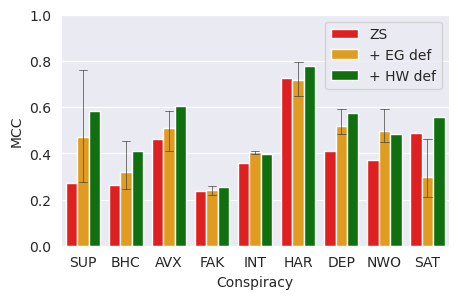

In [571]:
sn.set_style("darkgrid")
plt.ylim([0, 1.0])
col = ['red', 'orange', 'green', 'grey']
sn.barplot(tmp, x='Conspiracy', y='MCC', hue='Model', palette = col, errwidth=.5, capsize=.2, errorbar=("pi", 100))
plt.legend(loc='upper right')
plt.show()